<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [57]:
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# ## install finrl library
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [58]:
# !pip install optuna


<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [59]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline
import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")


from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent as OriginalDRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint


import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [60]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [61]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [62]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-03-01'

In [63]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                    end_date = TRADE_END_DATE,
                    ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
# yfp = YahooFinanceProcessor()
# df = yfp.download_data(['AXP', 'AMGN', 'AAPL'], '2010-01-01', '2010-02-01', '1m')
print(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (112073, 8)
Price         date       close        high         low        open     volume  \
0       2010-01-04    6.424604    6.439314    6.375672    6.407193  493729600   
1       2010-01-04   39.913254   40.016977   39.111116   39.159521    5277400   
2       2010-01-04   32.637955   32.781524   32.215226   32.550221    6894300   
3       2010-01-04   43.777554   43.941193   42.702205   43.419105    6186700   
4       2010-01-04   39.403461   39.834174   38.703553   38.797774    7325600   
...            ...         ...         ...         ...         ...        ...   
112068  2025-02-28  469.605164  470.989374  459.243337  461.734915    6146300   
112069  2025-02-28  361.472595  362.758203  352.503299  353.499887   15857300   
112070  2025-02-28   41.743721   42.382952   41.269142   42.063338   25197500   
112071  2025-02-28   10.680000   11.490000   10.480000   10.630000   52407400   
112072  2025-02-28   97.874153   98.122288   96.444896   97.060272   2545130

In [64]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [65]:
df.shape

(112073, 8)

In [66]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.424604,6.439314,6.375672,6.407193,493729600,AAPL,0
1,2010-01-04,39.913254,40.016977,39.111116,39.159521,5277400,AMGN,0
2,2010-01-04,32.637955,32.781524,32.215226,32.550221,6894300,AXP,0
3,2010-01-04,43.777554,43.941193,42.702205,43.419105,6186700,BA,0
4,2010-01-04,39.403461,39.834174,38.703553,38.797774,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [67]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

[*********************100%***********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (3812, 8)
Successfully added vix


Successfully added turbulence index


In [68]:
print(processed)

              date       close        high         low        open     volume  \
0       2010-01-04    6.424604    6.439314    6.375672    6.407193  493729600   
1       2010-01-04   39.913254   40.016977   39.111116   39.159521    5277400   
2       2010-01-04   32.637955   32.781524   32.215226   32.550221    6894300   
3       2010-01-04   43.777554   43.941193   42.702205   43.419105    6186700   
4       2010-01-04   39.403461   39.834174   38.703553   38.797774    7325600   
...            ...         ...         ...         ...         ...        ...   
110543  2025-02-27  463.277313  470.040193  459.777216  460.914274    4216800   
110544  2025-02-27  354.526367  359.080784  350.480220  350.699471    7298100   
110545  2025-02-27   41.908375   42.053652   41.540332   41.724355   19212300   
110546  2025-02-27   11.230000   11.850000   11.190000   11.700000   18971100   
110547  2025-02-27   96.067741   97.308414   95.095051   95.184383   16431500   

         tic  day       mac

In [69]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [70]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,6.424604,6.439314,6.375672,6.407193,493729600.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,6.424604,6.424604,20.040001,0.0
1,2010-01-04,AMGN,39.913254,40.016977,39.111116,39.159521,5277400.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,39.913254,39.913254,20.040001,0.0
2,2010-01-04,AXP,32.637955,32.781524,32.215226,32.550221,6894300.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,32.637955,32.637955,20.040001,0.0
3,2010-01-04,BA,43.777554,43.941193,42.702205,43.419105,6186700.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,43.777554,43.777554,20.040001,0.0
4,2010-01-04,CAT,39.403461,39.834174,38.703553,38.797774,7325600.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,39.403461,39.403461,20.040001,0.0
5,2010-01-04,CRM,18.542519,18.718477,18.386387,18.490475,7906000.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,18.542519,18.542519,20.040001,0.0
6,2010-01-04,CSCO,16.158167,16.256333,15.713146,15.778591,59853700.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,16.158167,16.158167,20.040001,0.0
7,2010-01-04,CVX,42.603535,42.678977,42.118550,42.140101,10173800.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,42.603535,42.603535,20.040001,0.0
8,2010-01-04,DIS,27.475880,28.058468,27.304531,27.844281,13700400.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,27.475880,27.475880,20.040001,0.0
9,2010-01-04,GS,131.991989,132.884238,129.269477,129.681291,9135000.0,0.0,0.0,6.445869,6.414449,100.0,66.666667,100.0,131.991989,131.991989,20.040001,0.0


In [71]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [72]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

100311
10237


In [73]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3458,2023-09-29,UNH,489.152191,494.672485,488.773809,494.643381,3006200.0,4.0,4.758825,499.945944,450.959736,55.148616,128.373238,19.202114,475.052336,477.039838,17.52,57.508326
3458,2023-09-29,V,226.621872,229.597391,226.267174,229.410187,6045200.0,4.0,-3.060778,250.759367,223.639090,41.887505,-154.262830,36.909018,237.730123,236.732695,17.52,57.508326
3458,2023-09-29,VZ,28.312365,28.609378,28.277421,28.495813,19787600.0,4.0,-0.276669,30.421853,28.184129,41.243791,-137.570672,33.867312,29.353076,29.363413,17.52,57.508326
3458,2023-09-29,WBA,20.083012,20.254585,18.854913,18.963276,25663400.0,4.0,-1.050146,20.962602,18.592987,36.119158,-53.011683,26.754730,20.958936,23.656805,17.52,57.508326
3458,2023-09-29,WMT,52.092018,53.134313,51.850984,53.101742,18842400.0,4.0,0.139503,54.027440,52.110901,50.578503,-24.941057,17.468249,52.619029,51.954637,17.52,57.508326


In [74]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.064636,172.609304,169.271983,169.559178,52164500.0,0.0,-2.558757,183.367368,165.648048,45.243152,-87.977238,26.128922,176.366170,180.804583,17.610001,34.480661
0,2023-10-02,AMGN,252.198318,254.262794,250.370595,253.524127,1912300.0,0.0,3.867164,261.151696,237.536335,59.425479,72.229099,31.543029,247.539644,237.412818,17.610001,34.480661
0,2023-10-02,AXP,145.907867,146.317829,144.531574,144.873201,2657600.0,0.0,-3.052553,160.817408,143.761845,37.445549,-174.733170,36.526671,153.348371,158.819425,17.610001,34.480661
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480661
0,2023-10-02,CAT,262.851044,267.774902,261.419340,263.741028,1778200.0,0.0,-0.878852,277.101120,259.928744,51.346807,-69.196757,1.038507,268.083487,264.021849,17.610001,34.480661


In [75]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [76]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [77]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [78]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [79]:

if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


In [80]:
import optuna
import numpy as np
from stable_baselines3 import DDPG, PPO, SAC, TD3
from stable_baselines3.common.noise import NormalActionNoise

class SingleObjectiveTuner:
    def __init__(self, env_train, e_train_gym, algo_name="ddpg", weight_sharpe=1.0, weight_dd=0.5):
        self.env_train = env_train
        self.e_train_gym = e_train_gym
        self.algo_name = algo_name.lower()
        self.weight_sharpe = weight_sharpe
        self.weight_dd = weight_dd
        assert self.algo_name in ["ddpg", "ppo", "sac", "td3"], f"{self.algo_name} not supported"

    def _sample_params(self, trial):
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
            "gamma": trial.suggest_float("gamma", 0.90, 0.999)
        }
        if self.algo_name in ["ddpg", "sac", "td3"]:
            params["tau"] = trial.suggest_float("tau", 0.001, 0.2)
        if self.algo_name in ["ddpg", "td3"]:
            params["noise_std"] = trial.suggest_float("noise_std", 0.05, 0.5)
        return params

    def _create_model(self, params):
        algo_cls = {"ddpg": DDPG, "ppo": PPO, "sac": SAC, "td3": TD3}[self.algo_name]
        kwargs = {
            "policy": "MlpPolicy",
            "env": self.env_train,
            "learning_rate": params["learning_rate"],
            "gamma": params["gamma"],
            "verbose": 0,
        }

        if self.algo_name in ["ddpg", "sac", "td3"]:
            kwargs["tau"] = params.get("tau", 0.005)
            kwargs["buffer_size"] = 50000
            kwargs["batch_size"] = 64
            kwargs["train_freq"] = (1, "step")

        if self.algo_name in ["ddpg", "td3"]:
            noise_std = params.get("noise_std", 0.1)
            n_actions = self.env_train.action_space.shape[-1]
            kwargs["action_noise"] = NormalActionNoise(
                mean=np.zeros(n_actions),
                sigma=noise_std * np.ones(n_actions)
            )

        return algo_cls(**kwargs)

    def _evaluate(self, model):
        df_account_value, _ = DRLAgent.DRL_prediction(model=model, environment=self.e_train_gym)
        daily_returns = df_account_value.account_value.pct_change().dropna()
        sharpe = np.mean(daily_returns) / (np.std(daily_returns) + 1e-9)
        drawdown = (df_account_value.account_value / df_account_value.account_value.cummax() - 1.0).min()
        return sharpe, drawdown

    def _objective(self, trial, total_timesteps):
        params = self._sample_params(trial)
        model = self._create_model(params)

        # Train in chunks and allow pruning
        step = 1000
        for t in range(step, total_timesteps + 1, step):
            model.learn(total_timesteps=step, reset_num_timesteps=False)
            sharpe, drawdown = self._evaluate(model)

            # Scalarized score
            score = self.weight_sharpe * sharpe - self.weight_dd * abs(drawdown)
            trial.report(score, t)

            if trial.should_prune():
                raise optuna.TrialPruned()

        return score

    def run(self, n_trials=10, total_timesteps=5000):
        print(f"🚀 Starting tuning with early stopping: {self.algo_name.upper()}")

        pruner = optuna.pruners.HyperbandPruner(min_resource=1000, max_resource=total_timesteps, reduction_factor=3)
        study = optuna.create_study(direction="maximize", pruner=pruner)
        study.optimize(lambda trial: self._objective(trial, total_timesteps), n_trials=n_trials)

        print("\n✅ Best Trial:")
        print(f"Score: {study.best_value:.4f}")
        print("Params:", study.best_params)

        return study.best_params, study.best_value


In [81]:
# Override DRLAgent with a wrapper
class DRLAgent(OriginalDRLAgent):
    def get_model(self, model_name, model_kwargs=None, **kwargs):
        model_kwargs = model_kwargs or {}
        noise_std = None

        # Extract noise_std for DDPG or TD3
        if model_name in ["ddpg", "td3"]:
            noise_std = model_kwargs.pop("noise_std", 0.1)

        # Call original get_model from base class
        model = super().get_model(model_name, model_kwargs=model_kwargs, **kwargs)

        # Attach action noise if needed
        if model_name in ["ddpg", "td3"] and noise_std is not None:
            n_actions = self.env.action_space.shape[-1]
            action_noise = NormalActionNoise(
                mean=np.zeros(n_actions),
                sigma=noise_std * np.ones(n_actions)
            )
            model.action_noise = action_noise

        return model

### Agent Training: 5 algorithms (DDPG, PPO, TD3, SAC)


### Agent 2: DDPG

In [82]:
# ✅ Use the fixed class
tuner = SingleObjectiveTuner(env_train, e_train_gym, algo_name="ddpg", weight_sharpe=1.0, weight_dd=0.5)

# ✅ Run tuning (with early stopping & scalarized objective)
best_params_ddpg, _ = tuner.run(n_trials=10, total_timesteps=5000)


# Train using your DRLAgent
agent = DRLAgent(env=env_train)
model_ddpg = agent.get_model("ddpg", model_kwargs=best_params_ddpg)


if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

[I 2025-08-17 17:03:32,066] A new study created in memory with name: no-name-8424206f-808e-4643-8f5f-35cf82cdbd04


🚀 Starting tuning with early stopping: DDPG


hit end!
hit end!
day: 3458, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5060629.77
total_reward: 4060629.77
total_cost: 1124.65
total_trades: 48455
Sharpe: 0.729
hit end!
hit end!


[I 2025-08-17 17:09:47,635] Trial 0 finished with value: -0.15100620616616994 and parameters: {'learning_rate': 0.00012264249869753762, 'gamma': 0.9591424165010878, 'tau': 0.05378392420787467, 'noise_std': 0.14632753763948805}. Best is trial 0 with value: -0.15100620616616994.


hit end!


[I 2025-08-17 17:10:58,555] Trial 1 pruned. 


day: 3458, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3913054.76
total_reward: 2913054.76
total_cost: 2802.19
total_trades: 57657
Sharpe: 0.629
hit end!
hit end!
hit end!
day: 3458, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 5367322.77
total_reward: 4367322.77
total_cost: 1133.85
total_trades: 58804
Sharpe: 0.752
hit end!
hit end!


[I 2025-08-17 17:15:46,746] Trial 2 finished with value: -0.14811748220337784 and parameters: {'learning_rate': 0.00038953150899030507, 'gamma': 0.9573902230582902, 'tau': 0.08269622095738122, 'noise_std': 0.26399074682289747}. Best is trial 2 with value: -0.14811748220337784.


hit end!


[I 2025-08-17 17:16:20,252] Trial 3 pruned. 


day: 3458, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 5716079.65
total_reward: 4716079.65
total_cost: 1717.75
total_trades: 52446
Sharpe: 0.789
hit end!
hit end!
hit end!
day: 3458, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 5796922.96
total_reward: 4796922.96
total_cost: 999.00
total_trades: 58765
Sharpe: 0.823
hit end!
hit end!


[I 2025-08-17 17:19:12,746] Trial 4 finished with value: -0.1373204877347629 and parameters: {'learning_rate': 0.0005394276716431044, 'gamma': 0.941221049366263, 'tau': 0.16264728669081427, 'noise_std': 0.25702517666931507}. Best is trial 4 with value: -0.1373204877347629.


hit end!


[I 2025-08-17 17:19:46,250] Trial 5 pruned. 


day: 3458, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 5386253.24
total_reward: 4386253.24
total_cost: 1371.57
total_trades: 38037
Sharpe: 0.773
hit end!
hit end!
hit end!
day: 3458, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 5780873.41
total_reward: 4780873.41
total_cost: 1263.36
total_trades: 48477
Sharpe: 0.844
hit end!
hit end!


[I 2025-08-17 17:24:34,265] Trial 6 finished with value: -0.09065878842152196 and parameters: {'learning_rate': 0.00019732238822721537, 'gamma': 0.9186993351144692, 'tau': 0.05905684263315729, 'noise_std': 0.3007165631823887}. Best is trial 6 with value: -0.09065878842152196.


hit end!


[I 2025-08-17 17:26:17,559] Trial 7 pruned. 


day: 3458, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 5235044.53
total_reward: 4235044.53
total_cost: 2030.83
total_trades: 38044
Sharpe: 0.730
hit end!


[I 2025-08-17 17:27:34,078] Trial 8 pruned. 


hit end!
hit end!
hit end!
hit end!
hit end!


[I 2025-08-17 17:35:40,820] Trial 9 finished with value: -0.10323608252439297 and parameters: {'learning_rate': 8.848693113043813e-05, 'gamma': 0.904196019227616, 'tau': 0.13006696628541917, 'noise_std': 0.36821509183656626}. Best is trial 6 with value: -0.09065878842152196.


day: 3458, episode: 100
begin_total_asset: 1000000.00
end_total_asset: 4976577.91
total_reward: 3976577.91
total_cost: 1615.68
total_trades: 51955
Sharpe: 0.758
hit end!

✅ Best Trial:
Score: -0.0907
Params: {'learning_rate': 0.00019732238822721537, 'gamma': 0.9186993351144692, 'tau': 0.05905684263315729, 'noise_std': 0.3007165631823887}
{'learning_rate': 0.00019732238822721537, 'gamma': 0.9186993351144692, 'tau': 0.05905684263315729, 'device': 'cuda'}
Using cuda device


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 0.73GB
  warnings.warn(


Logging to results/ddpg


In [83]:
trained_ddpg = model_ddpg.learn(total_timesteps=50000) if if_using_ddpg else None
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg2") if if_using_ddpg else None

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 27       |
|    time_elapsed    | 498      |
|    total_timesteps | 13836    |
| train/             |          |
|    actor_loss      | -1.43    |
|    critic_loss     | 10.4     |
|    learning_rate   | 0.000197 |
|    n_updates       | 13735    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 28       |
|    time_elapsed    | 960      |
|    total_timesteps | 27672    |
| train/             |          |
|    actor_loss      | -2.31    |
|    critic_loss     | 26.6     |
|    learning_rate   | 0.000197 |
|    n_updates       | 27571    |
---------------------------------
day: 3458, episode: 110
begin_total_asset: 1000000.00
end_total_asset: 5506143.54
total_reward: 4506143.54
total_cost: 1017.58
total_trades: 41471
Sharpe: 0.719
-----------------------

### Agent 3: PPO

In [84]:
# agent = DRLAgent(env = env_train)
# PPO_PARAMS = {
#     "n_steps": 2048,
#     "ent_coef": 0.01,
#     "learning_rate": 0.00025,
#     "batch_size": 128,
# }
# model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# Initialize tuner for PPO
tuner_ppo = SingleObjectiveTuner(env_train, e_train_gym, algo_name="ppo", weight_sharpe= 1.0, weight_dd= 0.5)
best_params_ppo, _ = tuner_ppo.run(n_trials=10, total_timesteps= 5000)

agent = DRLAgent(env=env_train)
model_ppo = agent.get_model("ppo", model_kwargs=best_params_ppo)



if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

[I 2025-08-17 18:04:47,490] A new study created in memory with name: no-name-36db0ae3-322d-4a7e-9631-35094b18f9cd


🚀 Starting tuning with early stopping: PPO


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!
hit end!
hit end!
hit end!


[I 2025-08-17 18:17:57,634] Trial 0 finished with value: -0.16932927992459706 and parameters: {'learning_rate': 2.8806142977235545e-05, 'gamma': 0.9381820379018773}. Best is trial 0 with value: -0.16932927992459706.


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!
hit end!
hit end!
hit end!


[I 2025-08-17 18:27:15,888] Trial 1 finished with value: -0.15567368824065042 and parameters: {'learning_rate': 0.00015543070004515498, 'gamma': 0.9967971263337605}. Best is trial 1 with value: -0.15567368824065042.


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!
hit end!
hit end!
day: 3458, episode: 160
begin_total_asset: 1000000.00
end_total_asset: 4817797.52
total_reward: 3817797.52
total_cost: 2614.50
total_trades: 44297
Sharpe: 0.735
hit end!


[I 2025-08-17 18:34:19,227] Trial 2 finished with value: -0.15824341327415142 and parameters: {'learning_rate': 0.000715847448632568, 'gamma': 0.9904202354004458}. Best is trial 1 with value: -0.15567368824065042.


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!
day: 3458, episode: 170
begin_total_asset: 1000000.00
end_total_asset: 2795018.69
total_reward: 1795018.69
total_cost: 1172.68
total_trades: 39535
Sharpe: 0.581
hit end!


[I 2025-08-17 18:36:13,343] Trial 3 pruned. 


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
[I 2025-08-17 18:36:51,569] Trial 4 pruned. 


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
[I 2025-08-17 18:37:30,326] Trial 5 pruned. 


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!
hit end!


[I 2025-08-17 18:39:26,530] Trial 6 pruned. 


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
[I 2025-08-17 18:40:05,201] Trial 7 pruned. 


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
[I 2025-08-17 18:40:44,346] Trial 8 pruned. 


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!
hit end!


[I 2025-08-17 18:42:40,880] Trial 9 pruned. 


hit end!

✅ Best Trial:
Score: -0.1557
Params: {'learning_rate': 0.00015543070004515498, 'gamma': 0.9967971263337605}
{'learning_rate': 0.00015543070004515498, 'gamma': 0.9967971263337605, 'device': 'cuda'}
Using cuda device
Logging to results/ppo


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [85]:
trained_ppo = model_ppo.learn(total_timesteps=200000)if if_using_ppo else None
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo2") if if_using_ppo else None

-----------------------------
| time/              |      |
|    fps             | 134  |
|    iterations      | 1    |
|    time_elapsed    | 15   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 2           |
|    time_elapsed         | 31          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011777846 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.00806     |
|    learning_rate        | 0.000155    |
|    loss                 | 3.39        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0245     |
|    std                  | 0.999       |
|    value_loss           | 10.7        |
----------------------------------

### Agent 4: TD3

In [86]:
# agent = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100,
#               "buffer_size": 1000000,
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

tuner_td3 = SingleObjectiveTuner(env_train, e_train_gym, algo_name="td3", weight_sharpe= 1.0, weight_dd= 0.5)
best_params_td3, _ = tuner_td3.run(n_trials=10, total_timesteps= 5000)

agent = DRLAgent(env=env_train)
model_td3 = agent.get_model("td3", model_kwargs=best_params_td3)



if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

[I 2025-08-17 19:10:42,735] A new study created in memory with name: no-name-12a81ee9-ff23-4c82-b701-b2dcc20c75a5


🚀 Starting tuning with early stopping: TD3
hit end!
hit end!
hit end!
hit end!


[I 2025-08-17 19:15:38,694] Trial 0 finished with value: -0.11495664084354412 and parameters: {'learning_rate': 0.00016336308988669062, 'gamma': 0.9088302417851758, 'tau': 0.1783311950624346, 'noise_std': 0.3381632458002944}. Best is trial 0 with value: -0.11495664084354412.


hit end!
hit end!
hit end!
hit end!
hit end!


[I 2025-08-17 19:18:32,749] Trial 1 finished with value: -0.13792563637911742 and parameters: {'learning_rate': 1.769367018373295e-05, 'gamma': 0.9550879426054794, 'tau': 0.046969816430305164, 'noise_std': 0.18106329770362545}. Best is trial 0 with value: -0.11495664084354412.


day: 3458, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 6087925.39
total_reward: 5087925.39
total_cost: 1672.11
total_trades: 41708
Sharpe: 0.828
hit end!
hit end!
hit end!
day: 3458, episode: 310
begin_total_asset: 1000000.00
end_total_asset: 6563107.27
total_reward: 5563107.27
total_cost: 998.99
total_trades: 31122
Sharpe: 0.834
hit end!
hit end!


[I 2025-08-17 19:21:28,158] Trial 2 finished with value: -0.15141217975504606 and parameters: {'learning_rate': 0.00022792645350213912, 'gamma': 0.9728392712379298, 'tau': 0.044601758790098214, 'noise_std': 0.07453536708298178}. Best is trial 0 with value: -0.11495664084354412.


hit end!


[I 2025-08-17 19:22:02,246] Trial 3 pruned. 


day: 3458, episode: 320
begin_total_asset: 1000000.00
end_total_asset: 6854664.45
total_reward: 5854664.45
total_cost: 2901.25
total_trades: 31774
Sharpe: 0.787
hit end!
hit end!
hit end!
day: 3458, episode: 330
begin_total_asset: 1000000.00
end_total_asset: 5915177.72
total_reward: 4915177.72
total_cost: 3191.21
total_trades: 49687
Sharpe: 0.861
hit end!
hit end!


[I 2025-08-17 19:24:55,994] Trial 4 finished with value: -0.10563195398467093 and parameters: {'learning_rate': 3.063254756517821e-05, 'gamma': 0.9204152909688567, 'tau': 0.18055671559756142, 'noise_std': 0.4914396143042293}. Best is trial 4 with value: -0.10563195398467093.


hit end!


[I 2025-08-17 19:25:30,761] Trial 5 pruned. 


day: 3458, episode: 340
begin_total_asset: 1000000.00
end_total_asset: 5063453.40
total_reward: 4063453.40
total_cost: 1490.82
total_trades: 69176
Sharpe: 0.741
hit end!


[I 2025-08-17 19:26:04,687] Trial 6 pruned. 


hit end!
hit end!
hit end!


[I 2025-08-17 19:27:49,976] Trial 7 pruned. 


hit end!


[I 2025-08-17 19:28:24,315] Trial 8 pruned. 


hit end!


[I 2025-08-17 19:28:58,553] Trial 9 pruned. 


hit end!

✅ Best Trial:
Score: -0.1056
Params: {'learning_rate': 3.063254756517821e-05, 'gamma': 0.9204152909688567, 'tau': 0.18055671559756142, 'noise_std': 0.4914396143042293}
{'learning_rate': 3.063254756517821e-05, 'gamma': 0.9204152909688567, 'tau': 0.18055671559756142, 'device': 'cuda'}
Using cuda device
Logging to results/td3


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 0.77GB
  warnings.warn(


In [87]:
trained_td3 = model_td3.learn(total_timesteps=50000) if if_using_td3 else None
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td32") if if_using_td3 else None


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 79       |
|    time_elapsed    | 174      |
|    total_timesteps | 13836    |
| train/             |          |
|    actor_loss      | 3.02     |
|    critic_loss     | 25.6     |
|    learning_rate   | 3.06e-05 |
|    n_updates       | 13735    |
---------------------------------
day: 3458, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 6679807.38
total_reward: 5679807.38
total_cost: 3952.83
total_trades: 55485
Sharpe: 0.860
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 79       |
|    time_elapsed    | 349      |
|    total_timesteps | 27672    |
| train/             |          |
|    actor_loss      | 4.13     |
|    critic_loss     | 20.8     |
|    learning_rate   | 3.06e-05 |
|    n_updates       | 27571    |
---------------------------------
-----------------------

### Agent 5: SAC

In [88]:
# agent = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 128,
#     "buffer_size": 100000,
#     "learning_rate": 0.0001,
#     "learning_starts": 100,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

tuner_sac = SingleObjectiveTuner(env_train, e_train_gym, algo_name="sac", weight_sharpe= 1.0, weight_dd= 0.5)
best_params_sac, _ = tuner_sac.run(n_trials=10, total_timesteps= 5000)

agent = DRLAgent(env=env_train)
model_sac = agent.get_model("sac", model_kwargs=best_params_sac)




if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

[I 2025-08-17 19:39:31,974] A new study created in memory with name: no-name-7df050e5-9fc7-4f28-ba06-58bbec306d14


🚀 Starting tuning with early stopping: SAC
hit end!
hit end!
hit end!
day: 3458, episode: 390
begin_total_asset: 1000000.00
end_total_asset: 3864863.30
total_reward: 2864863.30
total_cost: 1301.08
total_trades: 62280
Sharpe: 0.657
hit end!


[I 2025-08-17 19:42:50,466] Trial 0 finished with value: -0.12447072414868127 and parameters: {'learning_rate': 0.0001627975399127291, 'gamma': 0.9655504718253075, 'tau': 0.08585141807512792}. Best is trial 0 with value: -0.12447072414868127.


hit end!
hit end!
day: 3458, episode: 400
begin_total_asset: 1000000.00
end_total_asset: 6755507.34
total_reward: 5755507.34
total_cost: 5446.62
total_trades: 59179
Sharpe: 0.877
hit end!
hit end!
hit end!


[I 2025-08-17 19:48:17,881] Trial 1 finished with value: -0.09160543125369178 and parameters: {'learning_rate': 2.314706626972943e-05, 'gamma': 0.9194592488215333, 'tau': 0.026378094683278307}. Best is trial 1 with value: -0.09160543125369178.


hit end!
hit end!
hit end!


[I 2025-08-17 19:50:16,101] Trial 2 pruned. 


hit end!


[I 2025-08-17 19:50:55,026] Trial 3 pruned. 


hit end!
hit end!
day: 3458, episode: 430
begin_total_asset: 1000000.00
end_total_asset: 4644714.09
total_reward: 3644714.09
total_cost: 2220.75
total_trades: 65541
Sharpe: 0.682
hit end!


[I 2025-08-17 19:52:54,143] Trial 4 pruned. 


hit end!
hit end!
day: 3458, episode: 440
begin_total_asset: 1000000.00
end_total_asset: 5176720.72
total_reward: 4176720.72
total_cost: 1066.36
total_trades: 34632
Sharpe: 0.701
hit end!


[I 2025-08-17 19:54:52,048] Trial 5 pruned. 


hit end!
hit end!
day: 3458, episode: 450
begin_total_asset: 1000000.00
end_total_asset: 3792533.53
total_reward: 2792533.53
total_cost: 7080.08
total_trades: 49023
Sharpe: 0.585
hit end!


[I 2025-08-17 19:56:51,047] Trial 6 pruned. 


hit end!


[I 2025-08-17 19:57:30,858] Trial 7 pruned. 


hit end!


[I 2025-08-17 19:58:08,712] Trial 8 pruned. 


hit end!
hit end!
hit end!


[I 2025-08-17 20:00:08,196] Trial 9 pruned. 


hit end!

✅ Best Trial:
Score: -0.0916
Params: {'learning_rate': 2.314706626972943e-05, 'gamma': 0.9194592488215333, 'tau': 0.026378094683278307}
{'learning_rate': 2.314706626972943e-05, 'gamma': 0.9194592488215333, 'tau': 0.026378094683278307, 'device': 'cuda'}
Using cuda device


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 0.65GB
  warnings.warn(


Logging to results/sac


In [89]:
trained_sac =  model_sac.learn(total_timesteps=70000) if if_using_sac else None
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac2") if if_using_sac else None

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 59       |
|    time_elapsed    | 232      |
|    total_timesteps | 13836    |
| train/             |          |
|    actor_loss      | 3.18e+03 |
|    critic_loss     | 979      |
|    ent_coef        | 1.35     |
|    ent_coef_loss   | -47.6    |
|    learning_rate   | 2.31e-05 |
|    n_updates       | 13735    |
---------------------------------
day: 3458, episode: 480
begin_total_asset: 1000000.00
end_total_asset: 3317994.18
total_reward: 2317994.18
total_cost: 156901.92
total_trades: 57567
Sharpe: 0.628
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 59       |
|    time_elapsed    | 464      |
|    total_timesteps | 27672    |
| train/             |          |
|    actor_loss      | 3.73e+03 |
|    critic_loss     | 4.5e+03  |
|    ent_coef        | 1.85     |
|    ent_coef_loss   

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [90]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [91]:
insample_risk_indicator.vix.describe()

count    3459.000000
mean       18.633854
std         7.150486
min         9.140000
25%        13.705000
50%        16.870001
75%        21.570000
max        82.690002
Name: vix, dtype: float64

In [92]:
insample_risk_indicator.vix.quantile(0.996)

54.89679946899445

In [93]:
insample_risk_indicator.turbulence.describe()

count    3459.000000
mean       34.754940
std        42.349247
min         0.000000
25%        15.118130
50%        24.215572
75%        39.726971
max       652.503880
Name: turbulence, dtype: float64

In [94]:
insample_risk_indicator.turbulence.quantile(0.996)

263.50340154230355

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [95]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 55,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [96]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.064636,172.609304,169.271983,169.559178,52164500.0,0.0,-2.558757,183.367368,165.648048,45.243152,-87.977238,26.128922,176.366170,180.804583,17.610001,34.480661
0,2023-10-02,AMGN,252.198318,254.262794,250.370595,253.524127,1912300.0,0.0,3.867164,261.151696,237.536335,59.425479,72.229099,31.543029,247.539644,237.412818,17.610001,34.480661
0,2023-10-02,AXP,145.907867,146.317829,144.531574,144.873201,2657600.0,0.0,-3.052553,160.817408,143.761845,37.445549,-174.733170,36.526671,153.348371,158.819425,17.610001,34.480661
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480661
0,2023-10-02,CAT,262.851044,267.774902,261.419340,263.741028,1778200.0,0.0,-0.878852,277.101120,259.928744,51.346807,-69.196757,1.038507,268.083487,264.021849,17.610001,34.480661


In [97]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [98]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [99]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [100]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [101]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [102]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [103]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [104]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[172.065, 252.198, 145.908, ...,  27.745,  20.246,  52.147],
       [170.728, 247.179, 141.584, ...,  27.937,  20.363,  51.818],
       [171.976, 251.374, 143.126, ...,  27.552,  20.128,  52.441],
       ...,
       [246.437, 312.865, 291.633, ...,  42.335,  11.38 ,  96.961],
       [239.773, 303.696, 294.377, ...,  41.821,  11.04 ,  95.482],
       [236.721, 303.141, 292.488, ...,  41.908,  11.23 ,  96.068]])

In [105]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.111 0.065 0.06  0.069 0.072 0.095 0.047 0.052 0.044 0.041 0.089 0.065
 0.027 0.046 0.043 0.061 0.038 0.06  0.025 0.053 0.089 0.071 0.043 0.054
 0.099 0.084 0.027 0.012 0.048]
Variance-Covariance matrix of returns
 [[3.196 0.949 1.409 1.618 1.351 1.859 1.415 1.091 1.236 1.404 1.247 1.242
  1.022 1.667 0.667 1.294 0.693 0.835 1.068 0.693 1.739 1.329 0.696 0.837
  1.124 1.414 0.543 0.983 0.655]
 [0.949 2.305 1.006 0.93  0.992 1.097 0.964 0.865 0.875 1.039 0.921 0.973
  0.808 1.104 0.865 1.052 0.625 0.641 0.883 1.002 1.004 0.828 0.699 0.811
  1.076 0.98  0.609 0.998 0.61 ]
 [1.409 1.006 3.426 2.516 1.926 1.679 1.435 1.805 1.806 2.225 1.403 1.801
  1.314 1.58  0.805 2.337 0.971 1.053 1.399 0.877 1.435 1.546 0.723 1.464
  1.341 1.858 0.736 1.251 0.582]
 [1.618 0.93  2.516 5.157 2.126 1.819 1.487 2.018 1.951 2.194 1.527 2.079
  1.456 1.822 0.817 2.24  1.062 1.172 1.464 0.843 1.501 1.72  0.727 1.527
  1.376 1.734 0.721 1.417 0.597]
 [1.351 0.992 1.92

### Use PyPortfolioOpt

In [106]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([248190.,  14900.,      0.,      0.,      0.,   5590.,      0.,
            0.,      0.,      0., 190580.,      0.,      0.,      0.,
            0.,      0.,      0., 111530.,      0.,  24280.,  13000.,
            0.,      0.,      0., 277910.,  42680.,      0.,      0.,
        71340.])

In [107]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1463.822,   58.542,    0.   ,    0.   ,    0.   ,   27.808,
          0.   ,    0.   ,    0.   ,    0.   ,  658.71 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  441.225,
          0.   ,  248.607,   41.724,    0.   ,    0.   ,    0.   ,
        568.146,  188.331,    0.   ,    0.   , 1369.5  ])

In [108]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2023-10-02,1.005879e+06
2023-10-03,9.929164e+05
2023-10-04,9.981442e+05
2023-10-05,1.000998e+06
2023-10-06,1.008246e+06
...,...
2025-02-21,1.263438e+06
2025-02-24,1.261625e+06
2025-02-25,1.280903e+06
2025-02-26,1.259473e+06


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [109]:

df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)
df_account_value_ddpg.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_ddpg['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
print(result.head())
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
result.columns = ['ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']
print("result: ", result)
result.to_csv("result.csv")

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (354, 8)
Annual return          0.212792
Cumulative returns     0.311293
Annual volatility      0.112806
Sharpe ratio           1.771944
Calmar ratio           3.114398
Stability              0.889228
Max drawdown          -0.068325
Omega ratio            1.345059
Sortino ratio          2.692280
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.103019
Daily value at risk   -0.013419
dtype: float64
                    ddpg           td3           ppo           sac  \
date                                                                 
2023-10-02  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
2023-10-03  9.981585e+05  9.970450e+05  9.992644e+05  9.992176e+05   
2023-10-04  9.988964e+05  9.979980e+05  9.998966e+05  9.994939e+05   
2023-10-05  9.970550e+05  1.000577e+06  1.000019e+06  9.995369e+05   
2023-10-06  1.006416e+06  1.015024e+06  1.002740e+06  1.001425e+06   

    

<Figure size 1500x500 with 0 Axes>

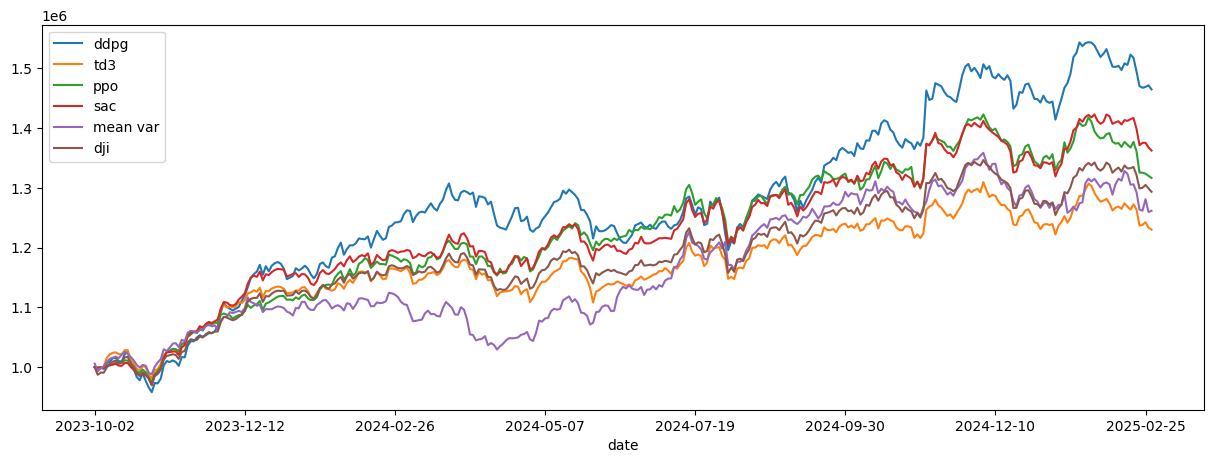

In [110]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();